# Plot contingency table results for single events and on maps


Plot skill metrics and contingency table results for single events on maps (Figures 3 and 4). Note that this notebook uses netcdf files instead of Climada exposures (available upon request from raphael.portmann@agroscope.admin.ch) 

In [1]:
import sys
from pathlib import Path
#add path to path of current skript, where also utility.py lies
sys.path.append(Path.cwd().absolute())
#own utility functions
from utility import data_dir,read_at_centroid_data,plot_measures_per_event, plot_CH_map

#others
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import pickle
import matplotlib.pyplot as plt


Specify details of the plot (Croptype, variable, resolutions etc) and directories

In [9]:
#%% SETUP
croptype='grapevine'
variable='MESHS'
varname='MZC'
dates=['2019-06-15','2021-06-28','2021-07-12'] #used for wheat in paper
dates=['2019-06-15','2021-06-28','2021-07-24'] #used for grapevine
resolutions=['1km','8km']

#minimum threshold (1 means at least one field required within grid cell)
thresh=1

# Directories
datadir = f"{data_dir}/data_at_centroid/"
figdir = 'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/fig/'
hazard_filedir =f"{data_dir}/MESHS_netcdf/"

In [3]:
data_dir

'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/code_and_data/data/'

Read hazard data from netcdf as xarray

In [3]:
### Read hazard data
#get start and end year
startyear=int(min([pd.Timestamp(d).year for d in dates]))
endyear=int(max([pd.Timestamp(d).year for d in dates]))
#hazard filenames
filenames={}
haz_xarray={}
filenames={}
for res in resolutions:
    filenames[res] = f'{hazard_filedir}MZC_12_events_2017_2021_max_{res}.nc'
    haz_xarray[res] = xr.open_dataset(filenames[res]) # extent=[5.5,10.5,45.5,48])   

Read at centroid data for contingency table results

In [10]:
#read at centroid data 
at_centroid_data, croptype = read_at_centroid_data(datadir,[croptype],variable=variable)

Read damage and exposure data from netcdf file

In [11]:
#read damage/exposure data
damages_exposure_data={}
filenames_dmg={}
for res in resolutions:
    if croptype=='grapevine':
        name='Reben'
    elif croptype=='wheat':
        name='Weizen'
    filenames_dmg[res]=f"{data_dir}/damage_exposure_netcdf/damage_claims_SHV_{name}_gridded_{res}.nc"
    damages_exposure_data[res]=xr.open_dataset(filenames_dmg[res]) # extent=[5.5,10.5,45.5,48])

Plot Figure

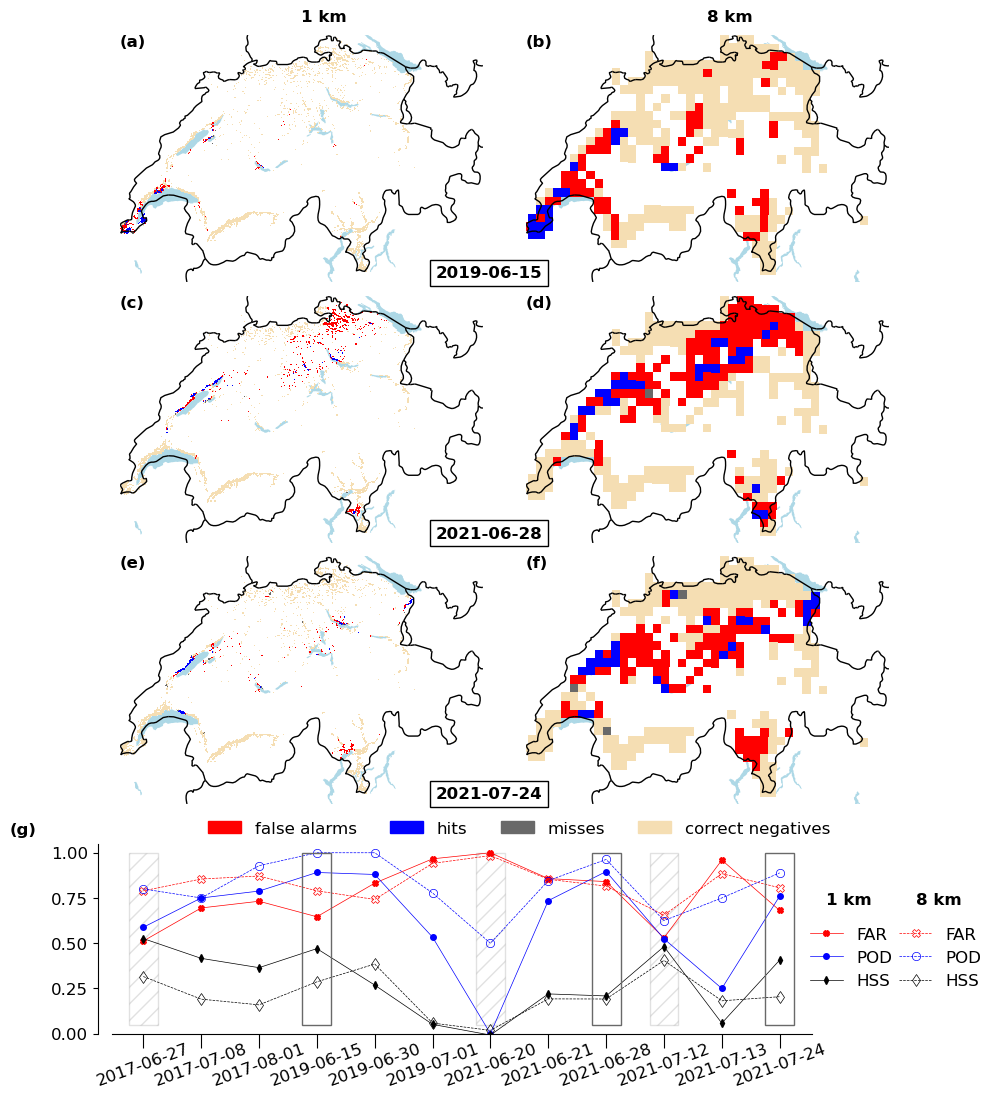

In [12]:
#setup
fontsize=12
labels=['(a)','(b)','(c)','(d)','(e)','(f)','(g)']
names=['false alarms','hits','misses','correct negatives']
matplotlib.rcParams.update({'font.size': fontsize,'axes.labelsize': fontsize,'axes.edgecolor': 'none'})
res_name=['1 km', '8 km']
#cmap
colors=['red','blue','dimgrey','wheat']
cMap = matplotlib.colors.ListedColormap(colors)
# create a patch (proxy artist) for every color to use in legend
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=colors[j], label=names[j]) for j in range(len(names))]


# Plot Figure
fig,axs,exts=plot_CH_map(nrows=3,ncols=2, figsize=(10,10), 
                            stamen_map=False, 
                            proj=ccrs.PlateCarree(),
                            pads=[0,0,0.1,0],
                            edgecolor='white')
                            #pads=[0.1,0.1,0.3,0.1],

#adjust white space between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.05)

#loop over dates and resolutons and data on map (panels a-f)
for i,date in enumerate(dates):

    for j,res in enumerate(resolutions):
        ax=axs[i*2+j]

        #plot row labels (dates)
        if j==1:
            if i==0:
                ax.text(-0.1,0.02,dates[i], ha='center', bbox=dict(facecolor='w'), transform=ax.transAxes,fontweight='bold',zorder=10)
            if i==1:
                ax.text(-0.1,0.02,dates[i], ha='center', bbox=dict(facecolor='w'), transform=ax.transAxes,fontweight='bold',zorder=10)
            if i==2:
                ax.text(-0.1,0.02,dates[i], ha='center', bbox=dict(facecolor='w'), transform=ax.transAxes,fontweight='bold',zorder=10)
        
        #plot panel labels
        if i==0:
            ax.text(0,0.95,labels[i*2+j], transform=ax.transAxes,fontweight='bold')
        if i==1:
            ax.text(0,0.95,labels[i*2+j], transform=ax.transAxes,fontweight='bold')
        if i==2:
            ax.text(0,0.95,labels[i*2+j], transform=ax.transAxes,fontweight='bold')                                
        
        #plot column labels
        if i==0:
            ax.text(0.5,1.05,res_name[j], transform=ax.transAxes,fontweight='bold')                                
  
        #get lonlat, hazard and damage data
        lon=haz_xarray[res].lon.values[0,:,:]
        lat=haz_xarray[res].lat.values[0,:,:]
        hazard_data=haz_xarray[res].sel(time=date)[varname]
        dmg_data=damages_exposure_data[res].sel(time=date)['n_fields_dmg']
    
        #prepare binary data
        predictions = np.where((hazard_data.values>0) & (damages_exposure_data[res]['n_fields_exp'].values>=thresh),1,0)
        damages=xr.where(dmg_data>0,2,0).values
        misses=np.where((hazard_data.fillna(0).values==0) & (dmg_data.values>0),3,0)
        correct_negatives=np.where((damages==0) & (predictions==0) & (damages_exposure_data[res]['n_fields_exp'].values>=thresh),4,0)
    
        #prepare data for plotting
        data = np.max([predictions,damages,misses,correct_negatives],axis=0)
        data = np.ma.masked_where(data == 0, data)

        #plot
        hs=ax.pcolormesh(lon,lat,data,
                         transform=ccrs.PlateCarree(),
                         cmap=cMap) #label='false alarms')
    
        if i>0:
            ax.set_facecolor('none')
  
        if i==2 and j==0:
            ax.legend(handles=patches,ncol=4,loc='center',bbox_to_anchor=(1.1, -0.1),edgecolor='none',facecolor='w',framealpha=1)    
            l=ax.get_legend()
            l.set_zorder(10)

#reset axes edgecolor from none to 'k'ArithmeticError
matplotlib.rcParams.update({'font.size': fontsize,'axes.edgecolor': 'k'})

#create additonal axes for time series plot
ax2=fig.add_axes([0.12,-0.12,0.7,0.19])
ax2.text(-0.145,1.05,labels[6], transform=ax2.transAxes,fontsize=fontsize,fontweight='bold')

#plot measures per event (panel g)
handles,labs,ax2,dates_all,npred_per_date,df_all_dates=\
    plot_measures_per_event(at_centroid_data,
                            variable,
                            ax2,
                            measures=['FAR','POD','HSS'],
                            thresh=thresh,
                            fontsize=fontsize)

#format axis
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20,fontsize=fontsize)
ax2.spines[['left']].set_position(('outward', 10))
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([0,1.05])

#add legend
leg=ax2.legend(handles=handles,labels=labs,ncol=2,loc='center',bbox_to_anchor=(1.12,0.4),edgecolor='none',facecolor='none',columnspacing=0.4)
leg._legend_box.align = "left"
ax2.text(1.02,0.68,'1 km', transform=ax2.transAxes,fontsize=fontsize,fontweight='bold')
ax2.text(1.15,0.68,'8 km', transform=ax2.transAxes,fontsize=fontsize,fontweight='bold')

#add black boxes for dates shown in panels a-f
for i,date in enumerate(dates):
    ind= dates_all.index(pd.Timestamp(date))
    x0=ax2.get_xticks()[ind]-0.25
    rectangle = mpatches.Rectangle((x0, 0.05), 0.5, 0.95, edgecolor='dimgrey',
    facecolor="none", linewidth=1,zorder=10)
    ax2.add_patch(rectangle)

#mark dates with very low number of predictions with grey hatched boxes 
for i,date in enumerate(dates_all):
    if npred_per_date['1km'][i]<80:
        x0=ax2.get_xticks()[i]-0.25
        rectangle = mpatches.Rectangle((x0, 0.05), 0.5, 0.95, edgecolor='dimgrey',
        facecolor="none", hatch='//',linewidth=1,zorder=0,alpha=0.2)
        ax2.add_patch(rectangle)   
ax2.tick_params('x', length=10,pad=-5)

Now save figure

In [8]:
fig.savefig(f'{figdir}/Figure_04_{croptype}_{resolutions[0]}_{resolutions[1]}_{thresh}.pdf',dpi=100,bbox_inches='tight')
fig.savefig(f'{figdir}/Figure_04_{croptype}_{resolutions[0]}_{resolutions[1]}_{thresh}.png',dpi=100,bbox_inches='tight')
